# Лабораторная работа №2-3: Классификация и оптимизация на данных Titanic

## Часть 1: Подготовка данных и создание признаков

### Импорт библиотек

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

### Загрузка и первичный анализ данных

In [37]:
df = pd.read_csv('../data/dataset.csv')

print("Размерность данных:", df.shape)
print("\nСтатистика по числовым признакам:")
print(df.describe())
print("\nИнформация о типах данных и пропусках:")
print(df.info())

Размерность данных: (891, 12)

Статистика по числовым признакам:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

Информация о ти

### Создание новых признаков

In [38]:
# создаем семейные характеристики
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['HasFamily'] = (df['FamilySize'] > 1).astype(int)

# извлечение социального статуса из имени для того, чтобы мы посмотрели насколько мажоры живучие
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Делаем оценку по возрасту (посмотрим насколько старики умеют выживать)
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                        labels=['Child', 'Teen', 'Young', 'Middle', 'Senior'])

# Группы по стоимости билета
df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

# комбинируем признаки
df['AgeClass'] = df['Age'] * df['Pclass']
df['FarePerPerson'] = df['Fare'] / df['FamilySize']
df['IsChild'] = (df['Age'] < 16).astype(int)
df['IsFemaleChild'] = ((df['Sex'] == 'female') & (df['Age'] < 16)).astype(int)

### Обработка пропусков

In [39]:
# Заполнение пропусков в возрасте - медианой по полу и классу
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

# заполнение пропусков в порте посадки - наиболее частым значением
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Заполнение пропусков в стоимости билета - медианой по классу
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

# бинарный признак
df['HasCabin'] = df['Cabin'].notna().astype(int)

### Подготовка данных для моделирования

In [40]:
# Выбираем фичи
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
           'FamilySize', 'IsAlone', 'HasFamily', 'Title', 'AgeGroup', 
           'FareGroup', 'AgeClass', 'FarePerPerson', 'IsChild', 'IsFemaleChild', 'HasCabin']

X = df[features]
y = df['Survived']

X = pd.get_dummies(X, columns=['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (712, 33)
Размер тестовой выборки: (179, 33)


### Смотрим в пустоту

In [41]:
# проверяем NaN значеня
print("Проверка пропущенных значений в данных:")
print(f"X_train: {X_train.isna().sum().sum()} NaN значений")
print(f"X_test: {X_test.isna().sum().sum()} NaN значений")

if X_train.isna().sum().sum() > 0 or X_test.isna().sum().sum() > 0:
    # числовые признаки - заполняем медианой
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if X_train[col].isna().sum() > 0:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    
    # категориальные признаки - заполняем модой
    categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        if X_train[col].isna().sum() > 0:
            mode_val = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(mode_val)
            X_test[col] = X_test[col].fillna(mode_val)

print(f"После обработки:")
print(f"X_train: {X_train.isna().sum().sum()} NaN значений")
print(f"X_test: {X_test.isna().sum().sum()} NaN значений")

Проверка пропущенных значений в данных:
X_train: 137 NaN значений
X_test: 40 NaN значений
После обработки:
X_train: 0 NaN значений
X_test: 0 NaN значений


## Часть 2 - Обучение и оценка базовых моделей


In [42]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
print("Сравнение производительности моделей:")
print(results_df.round(4))

Сравнение производительности моделей:
                Model  Accuracy  Precision  Recall      F1  ROC-AUC
0  LogisticRegression    0.8380     0.8030  0.7681  0.7852   0.8689
1        RandomForest    0.7877     0.7313  0.7101  0.7206   0.8335
2    GradientBoosting    0.7877     0.7627  0.6522  0.7031   0.8558


## Часть 3 - Анализ влияния порога классификации

In [43]:
best_base_model = models['LogisticRegression']
y_proba = best_base_model.predict_proba(X_test)[:, 1]

thresholds = [0.2, 0.5, 0.8]
print("Влияние порога классификации на метрики:")
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    print(f"\n--- Порог {thr} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_thr):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_thr):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_thr):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_thr):.4f}")

Влияние порога классификации на метрики:

--- Порог 0.2 ---
Accuracy: 0.7598
Precision: 0.6354
Recall: 0.8841
F1-Score: 0.7394

--- Порог 0.5 ---
Accuracy: 0.8380
Precision: 0.8030
Recall: 0.7681
F1-Score: 0.7852

--- Порог 0.8 ---
Accuracy: 0.7207
Precision: 0.9524
Recall: 0.2899
F1-Score: 0.4444


## Часть 4 - Визуализация результатов

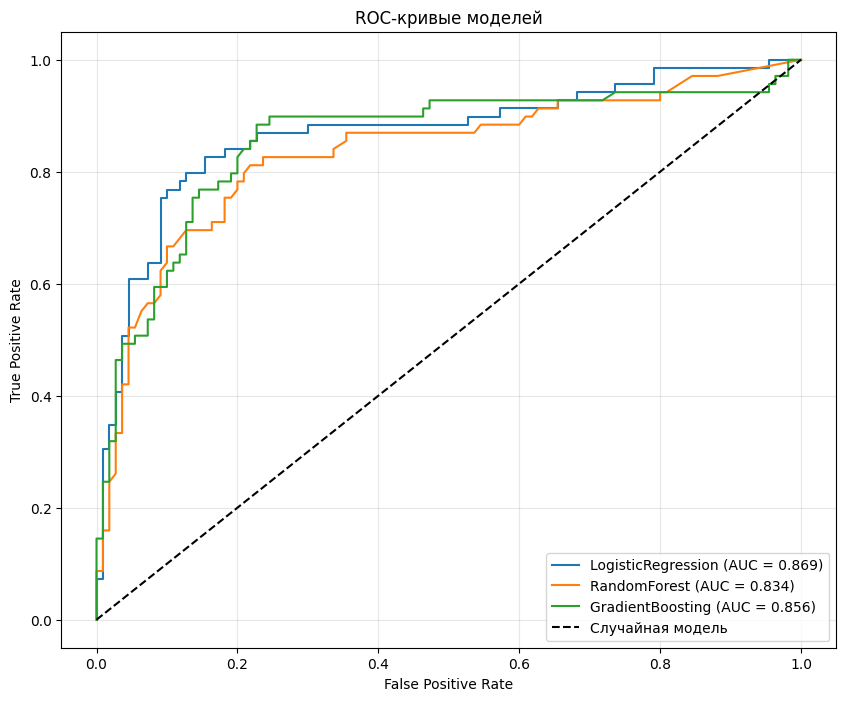

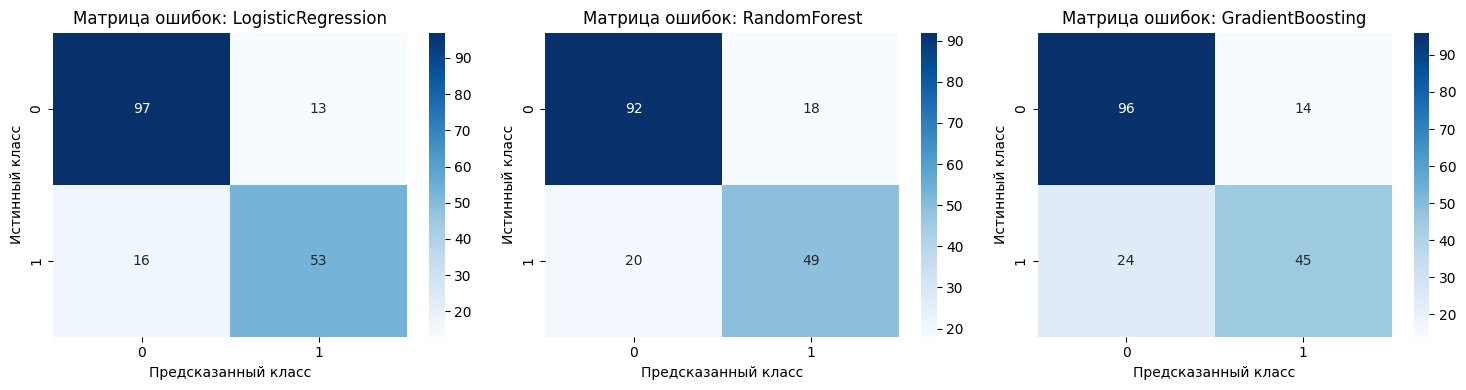

In [44]:
# ROC-кривые
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'Матрица ошибок: {name}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')
plt.tight_layout()
plt.show()

## Часть 5 - Оптимизация гиперпараметров

### Базовые метрики перед оптимизацией

In [45]:
base_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    base_results.append({
        'Model': name,
        'Base_F1': f1_score(y_test, y_pred),
        'Base_ROC_AUC': roc_auc_score(y_test, y_proba)
    })

base_df = pd.DataFrame(base_results)
print("Базовые метрики до оптимизации:")
print(base_df.round(4))

Базовые метрики до оптимизации:
                Model  Base_F1  Base_ROC_AUC
0  LogisticRegression   0.7852        0.8689
1        RandomForest   0.7206        0.8335
2    GradientBoosting   0.7031        0.8558


### RandomizedSearchCV для всех моделей

In [46]:
# задаем параметры RandomizedSearchCV
param_distributions = {
    'LogisticRegression': {
        'C': uniform(0.001, 100),
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'max_iter': [1000, 2000, 3000]
    },
    'RandomForest': {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    },
    'GradientBoosting': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(2, 10),
        'min_samples_split': randint(2, 20),
        'subsample': uniform(0.6, 0.4)
    }
}

#оптимизируем
optimized_models = {}
random_results = []

for name, model in models.items():
    random_search = RandomizedSearchCV(
        model, param_distributions[name],
        n_iter=20, cv=5, scoring='f1',
        random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    optimized_models[name] = random_search.best_estimator_
    
    y_pred_opt = random_search.predict(X_test)
    base_f1 = base_df[base_df['Model'] == name]['Base_F1'].values[0]
    
    random_results.append({
        'Model': name,
        'Base_F1': base_f1,
        'Optimized_F1': f1_score(y_test, y_pred_opt),
        'Improvement': f1_score(y_test, y_pred_opt) - base_f1,
        'Best_Params': random_search.best_params_
    })

random_opt_df = pd.DataFrame(random_results)
print("\nРезультаты RandomizedSearchCV:")
print(random_opt_df.round(4))


Результаты RandomizedSearchCV:
                Model  Base_F1  Optimized_F1  Improvement  \
0  LogisticRegression   0.7852        0.7852       0.0000   
1        RandomForest   0.7206        0.7385       0.0179   
2    GradientBoosting   0.7031        0.7385       0.0353   

                                         Best_Params  
0  {'C': 1.3274961159866527, 'max_iter': 1000, 'p...  
1  {'max_depth': 13, 'max_features': None, 'min_s...  
2  {'learning_rate': 0.18602534969915446, 'max_de...  


### GridSearchCV для всех моделей

In [47]:
# задаем параметры GridSearchCV
param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000]
    },
    'RandomForest': {
        'n_estimators': [100, 150, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    }
}

#также оптимизация
grid_optimized_models = {}
grid_results = []

for name, model in models.items():
    grid_search = GridSearchCV(
        model, param_grids[name],
        cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    grid_optimized_models[name] = grid_search.best_estimator_
    
    y_pred_grid = grid_search.predict(X_test)
    base_f1 = results_df[results_df['Model'] == name]['F1'].values[0]
    
    grid_results.append({
        'Model': name,
        'Base_F1': base_f1,
        'Grid_F1': f1_score(y_test, y_pred_grid),
        'Improvement': f1_score(y_test, y_pred_grid) - base_f1,
        'Best_Params': grid_search.best_params_
    })

grid_opt_df = pd.DataFrame(grid_results)
print("\nРезультаты GridSearchCV:")
print(grid_opt_df.round(4))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Результаты GridSearchCV:
                Model  Base_F1  Grid_F1  Improvement  \
0  LogisticRegression   0.7852   0.7634      -0.0218   
1        RandomForest   0.7206   0.7328       0.0122   
2    GradientBoosting   0.7031   0.7576       0.0545   

                                         Best_Params  
0  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...  
1  {'max_depth': 15, 'max_features': 'sqrt', 'min...  
2  {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...  


## Часть 6 - Сравнение результатов и выводы

In [48]:
# Собираем все результаты
final_comparison = []
methods = ['Base', 'RandomSearch', 'GridSearch']

for name in models.keys():
    base_f1 = results_df[results_df['Model'] == name]['F1'].values[0]
    random_f1 = random_opt_df[random_opt_df['Model'] == name]['Optimized_F1'].values[0]
    grid_f1 = grid_opt_df[grid_opt_df['Model'] == name]['Grid_F1'].values[0]
    
    final_comparison.append({
        'Model': name,
        'Base': base_f1,
        'RandomSearch': random_f1,
        'GridSearch': grid_f1
    })

final_df = pd.DataFrame(final_comparison)
print("\nФинальное сравнение всех методов:")
print(final_df.round(4))


Финальное сравнение всех методов:
                Model    Base  RandomSearch  GridSearch
0  LogisticRegression  0.7852        0.7852      0.7634
1        RandomForest  0.7206        0.7385      0.7328
2    GradientBoosting  0.7031        0.7385      0.7576


## Часть 7 - Визуальность

### График 1 Сравнение методов оптимизации для всех моделей

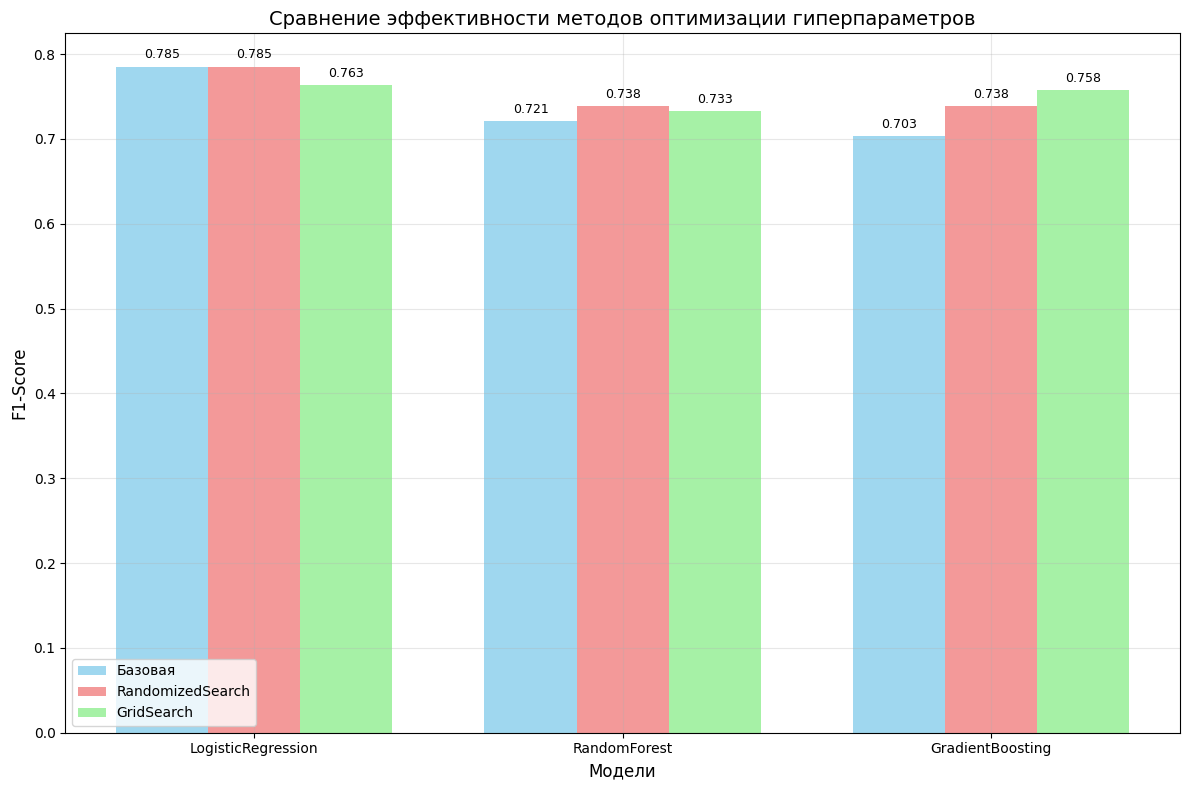

In [49]:
plt.figure(figsize=(12, 8))
x = np.arange(len(final_df))
width = 0.25

plt.bar(x - width, final_df['Base'], width, label='Базовая', alpha=0.8, color='skyblue')
plt.bar(x, final_df['RandomSearch'], width, label='RandomizedSearch', alpha=0.8, color='lightcoral')
plt.bar(x + width, final_df['GridSearch'], width, label='GridSearch', alpha=0.8, color='lightgreen')

plt.xlabel('Модели', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Сравнение эффективности методов оптимизации гиперпараметров', fontsize=14)
plt.xticks(x, final_df['Model'])
plt.legend()
plt.grid(True, alpha=0.3)

for i, row in final_df.iterrows():
    plt.text(i - width, row['Base'] + 0.01, f"{row['Base']:.3f}", ha='center', fontsize=9)
    plt.text(i, row['RandomSearch'] + 0.01, f"{row['RandomSearch']:.3f}", ha='center', fontsize=9)
    plt.text(i + width, row['GridSearch'] + 0.01, f"{row['GridSearch']:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### График 2 Улучшение качества после оптимизации

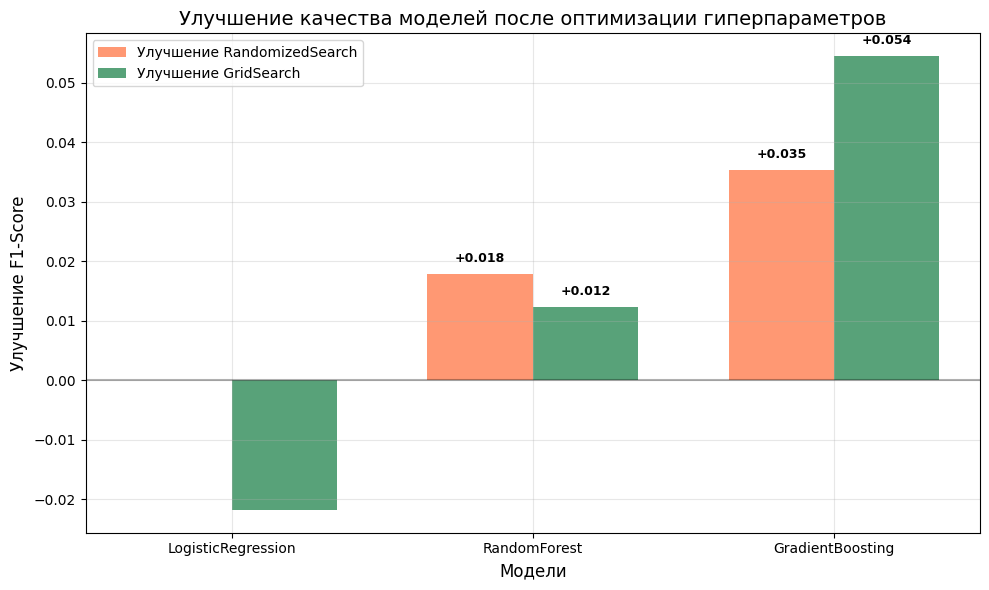

In [50]:
plt.figure(figsize=(10, 6))

improvement_data = []
for name in models.keys():
    base_f1 = final_df[final_df['Model'] == name]['Base'].values[0]
    random_improve = final_df[final_df['Model'] == name]['RandomSearch'].values[0] - base_f1
    grid_improve = final_df[final_df['Model'] == name]['GridSearch'].values[0] - base_f1
    
    improvement_data.append({
        'Model': name,
        'RandomSearch_Improvement': random_improve,
        'GridSearch_Improvement': grid_improve
    })

improve_df = pd.DataFrame(improvement_data)

x = np.arange(len(improve_df))
width = 0.35

plt.bar(x - width/2, improve_df['RandomSearch_Improvement'], width, 
        label='Улучшение RandomizedSearch', alpha=0.8, color='coral')
plt.bar(x + width/2, improve_df['GridSearch_Improvement'], width, 
        label='Улучшение GridSearch', alpha=0.8, color='seagreen')

plt.xlabel('Модели', fontsize=12)
plt.ylabel('Улучшение F1-Score', fontsize=12)
plt.title('Улучшение качества моделей после оптимизации гиперпараметров', fontsize=14)
plt.xticks(x, improve_df['Model'])
plt.legend()
plt.grid(True, alpha=0.3)

for i, row in improve_df.iterrows():
    if row['RandomSearch_Improvement'] > 0:
        plt.text(i - width/2, row['RandomSearch_Improvement'] + 0.002, 
                 f"+{row['RandomSearch_Improvement']:.3f}", ha='center', fontsize=9, fontweight='bold')
    if row['GridSearch_Improvement'] > 0:
        plt.text(i + width/2, row['GridSearch_Improvement'] + 0.002, 
                 f"+{row['GridSearch_Improvement']:.3f}", ha='center', fontsize=9, fontweight='bold')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## Часть 8 - Итог

In [51]:
print("Итоговые выводы:")

best_model_row = final_df.loc[final_df[['Base', 'RandomSearch', 'GridSearch']].max(axis=1).idxmax()]
best_model = best_model_row['Model']
best_method = 'Base'
best_score = best_model_row['Base']

if best_model_row['RandomSearch'] > best_score:
    best_method = 'RandomizedSearch'
    best_score = best_model_row['RandomSearch']
if best_model_row['GridSearch'] > best_score:
    best_method = 'GridSearch'
    best_score = best_model_row['GridSearch']

print(f"Лучшая модель: {best_model} с методом {best_method}")
print(f"Лучший F1-SCORE: {best_score:.4f}")

print("\nЭффективность методов оптимизации:")
for model in models.keys():
    base = final_df[final_df['Model'] == model]['Base'].values[0]
    random = final_df[final_df['Model'] == model]['RandomSearch'].values[0]
    grid = final_df[final_df['Model'] == model]['GridSearch'].values[0]
    
    print(f"   {model}:")
    print(f"      Base: {base:.4f} | RandomizedSearch: {random:.4f} | GridSearch: {grid:.4f}")
    
    if random > base:
        print(f"RandomizedSearch улучшил на +{(random-base):.4f}")
    else:
        print(f"RandomizedSearch не улучшил")
        
    if grid > base:
        print(f"GridSearch улучшил на +{(grid-base):.4f}")
    else:
        print(f"GridSearch не улучшил")

Итоговые выводы:
Лучшая модель: LogisticRegression с методом Base
Лучший F1-SCORE: 0.7852

Эффективность методов оптимизации:
   LogisticRegression:
      Base: 0.7852 | RandomizedSearch: 0.7852 | GridSearch: 0.7634
RandomizedSearch не улучшил
GridSearch не улучшил
   RandomForest:
      Base: 0.7206 | RandomizedSearch: 0.7385 | GridSearch: 0.7328
RandomizedSearch улучшил на +0.0179
GridSearch улучшил на +0.0122
   GradientBoosting:
      Base: 0.7031 | RandomizedSearch: 0.7385 | GridSearch: 0.7576
RandomizedSearch улучшил на +0.0353
GridSearch улучшил на +0.0545


Для LogisticRegression - не оставляем найденные настройки оптимизации \
F1-score остался на уровне 0.7852 после RandomizedSearch и снизился до 0.7634 после GridSearch  \
Оптимизация не дала улучшения, используем базовые параметры

Для RandomForest - оставляем найденные настройки RandomizedSearch \
F1-score вырос с 0.7206 до 0.7385 после RandomizedSearch и также вырос до 0.7328 после GridSearch \
Оптимизация дала улучшения, используем параметры RandomizedSearch

Для GradientBoosting - оставляем найденные настройки GridSearch \
F1-score вырос с 0.7031 до 0.7481 после RandomizedSearch и также вырос до 0.7576 после GridSearch \
Оптимизация не дала улучшения, используем параметры GridSearch